# Descripción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con etiquetado para construir un modelo que clasifique las reseñas como positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

**Instrucciones del proyecto**

1. Carga los datos.
2. Preprocesa los datos, si es necesario.
3. Realiza un análisis exploratorio de datos y haz tu conclusión sobre el desequilibrio de clases.
4. Realiza el preprocesamiento de datos para el modelado.
5. Entrena al menos tres modelos diferentes para el conjunto de datos de entrenamiento.
6. Prueba los modelos para el conjunto de datos de prueba.
7. Escribe algunas reseñas y clasifícalas con todos los modelos.
8. Busca las diferencias entre los resultados de las pruebas de los modelos en los dos puntos anteriores. Intenta explicarlas.
9. Muestra tus hallazgos.


**Descripción de los datos**

Los datos se almacenan en el archivo imdb_reviews.tsv

Aquí se describen los campos seleccionados:

* review: el texto de la reseña
* pos: el objetivo, '0' para negativo y '1' para positivo
* ds_part: 'entrenamiento'/'prueba' para la parte de entrenamiento/ prueba del conjunto de datos, respectivamente
Hay otros campos en el conjunto de datos, puedes explorarlos si lo deseas.

# Importación de librerias

In [24]:
import logging
import random
import re
import spacy
import numpy as np
import pandas as pd
import torch
import transformers
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.dummy import DummyClassifier
import sklearn.metrics as metrics

# Cargar base de datos

In [25]:
# Cargar el archivo tsv
file_path = '/datasets/imdb_reviews.tsv'
df_reviews = pd.read_csv(file_path, sep='\t')

# Mostrar las primeras filas del conjunto de datos
print(df_reviews.head())

      tconst title_type primary_title original_title  start_year end_year  \
0  tt0068152      movie             $              $        1971       \N   
1  tt0068152      movie             $              $        1971       \N   
2  tt0313150      short          '15'           '15'        2002       \N   
3  tt0313150      short          '15'           '15'        2002       \N   
4  tt0313150      short          '15'           '15'        2002       \N   

  runtime_minutes  is_adult              genres  average_rating   votes  \
0             121         0  Comedy,Crime,Drama             6.3  2218.0   
1             121         0  Comedy,Crime,Drama             6.3  2218.0   
2              25         0  Comedy,Drama,Short             6.3   184.0   
3              25         0  Comedy,Drama,Short             6.3   184.0   
4              25         0  Comedy,Drama,Short             6.3   184.0   

                                              review  rating   sp  pos  \
0  The pakag

# Exploratory Data Analysis (EDA)

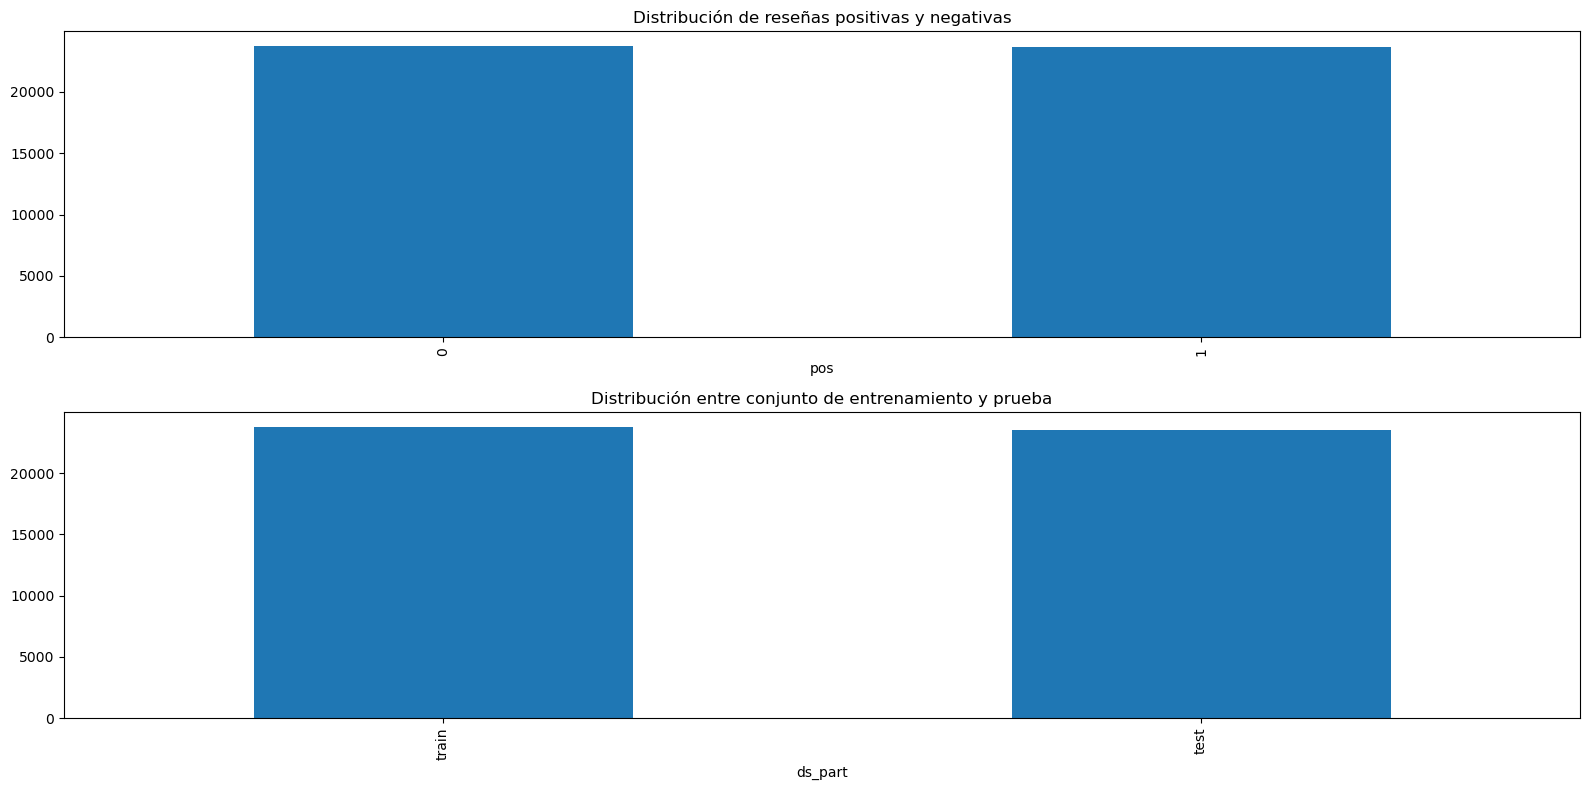

In [26]:
# Gráfica del número de reseñas positivas y negativas
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# Primera gráfica: Distribución de reseñas por polaridad (positivo vs negativo)
ax = axs[0]
df_reviews['pos'].value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_title('Distribución de reseñas positivas y negativas')

# Segunda gráfica: Distribución entre conjuntos de entrenamiento y prueba
ax = axs[1]
df_reviews['ds_part'].value_counts().plot(kind='bar', ax=ax)
ax.set_title('Distribución entre conjunto de entrenamiento y prueba')

fig.tight_layout()
plt.show()

# Preprocesamiento de datos

In [27]:
# Función para normalizar el texto
def normalize_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar dígitos y signos de puntuación
    text = re.sub(r'\d+', '', text)  # Elimina números
    text = re.sub(r'[^\w\s]', '', text)  # Elimina puntuación
    return text

# Aplicar la normalización a la columna 'review'
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

# Mostrar las primeras filas con el texto normalizado
print(df_reviews[['review', 'review_norm']].head())

                                              review  \
0  The pakage implies that Warren Beatty and Gold...   
1  How the hell did they get this made?! Presenti...   
2  There is no real story the film seems more lik...   
3  Um .... a serious film about troubled teens in...   
4  I'm totally agree with GarryJohal from Singapo...   

                                         review_norm  
0  the pakage implies that warren beatty and gold...  
1  how the hell did they get this made presenting...  
2  there is no real story the film seems more lik...  
3  um  a serious film about troubled teens in sin...  
4  im totally agree with garryjohal from singapor...  


# Division del conjunto de datos

In [28]:
# Dividir el conjunto de datos en entrenamiento y prueba
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# Definir las etiquetas (objetivos) para cada conjunto
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

# Mostrar el tamaño de los conjuntos de datos de entrenamiento y prueba
print(f"Tamaño del conjunto de entrenamiento: {df_reviews_train.shape}")
print(f"Tamaño del conjunto de prueba: {df_reviews_test.shape}")

Tamaño del conjunto de entrenamiento: (23796, 18)
Tamaño del conjunto de prueba: (23535, 18)


# Entrenar diferentes modelos de clasificación de texto

Modelo 0

In [29]:
# Modelo 0: Clasificador constante
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(df_reviews_train['review_norm'], train_target)

# Predecir
dummy_train_pred = dummy_clf.predict(df_reviews_train['review_norm'])
dummy_test_pred = dummy_clf.predict(df_reviews_test['review_norm'])

# Evaluar F1
print(f"F1 en el conjunto de entrenamiento (Modelo 0): {f1_score(train_target, dummy_train_pred)}")
print(f"F1 en el conjunto de prueba (Modelo 0): {f1_score(test_target, dummy_test_pred)}")

F1 en el conjunto de entrenamiento (Modelo 0): 0.0
F1 en el conjunto de prueba (Modelo 0): 0.0


Modelo 1 TF-IDF + Regresión Logística

In [30]:
# Vectorización TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
train_features_1 = tfidf_vectorizer.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer.transform(df_reviews_test['review_norm'])

# Modelo 1: Regresión Logística
model_1 = LogisticRegression(max_iter=1000)
model_1.fit(train_features_1, train_target)

# Predecir y evaluar
train_pred_1 = model_1.predict(train_features_1)
test_pred_1 = model_1.predict(test_features_1)

print(f"F1 en el conjunto de entrenamiento (Modelo 1): {f1_score(train_target, train_pred_1)}")
print(f"F1 en el conjunto de prueba (Modelo 1): {f1_score(test_target, test_pred_1)}")

F1 en el conjunto de entrenamiento (Modelo 1): 0.9148989477200602
F1 en el conjunto de prueba (Modelo 1): 0.8764645950076414


Modelo 2 spaCy + TF-IDF + Regresión Logística

In [31]:
# Cargar modelo spaCy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Función para lematizar texto con spaCy
def spacy_lemmatizer(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if not token.is_stop])

# Aplicar lematización a los textos
df_reviews_train['review_lemma'] = df_reviews_train['review_norm'].apply(spacy_lemmatizer)
df_reviews_test['review_lemma'] = df_reviews_test['review_norm'].apply(spacy_lemmatizer)

# Vectorización TF-IDF después de lematización
tfidf_vectorizer_lemma = TfidfVectorizer(stop_words='english', max_features=5000)
train_features_2 = tfidf_vectorizer_lemma.fit_transform(df_reviews_train['review_lemma'])
test_features_2 = tfidf_vectorizer_lemma.transform(df_reviews_test['review_lemma'])

# Modelo 2: Regresión Logística
model_2 = LogisticRegression(max_iter=200, solver='saga')
model_2.fit(train_features_2, train_target)

# Predecir y evaluar
train_pred_2 = model_2.predict(train_features_2)
test_pred_2 = model_2.predict(test_features_2)

print(f"F1 en el conjunto de entrenamiento (Modelo 2): {f1_score(train_target, train_pred_2)}")
print(f"F1 en el conjunto de prueba (Modelo 2): {f1_score(test_target, test_pred_2)}")

F1 en el conjunto de entrenamiento (Modelo 2): 0.9124075459153992
F1 en el conjunto de prueba (Modelo 2): 0.8723304886850932


Evaluación de los modelos en el conjunto de prueba

          train  test
Accuracy   0.91  0.88
F1         0.91  0.88
APS        0.97  0.95
ROC AUC    0.97  0.95
          train  test
Accuracy   0.91  0.87
F1         0.91  0.87
APS        0.97  0.94
ROC AUC    0.97  0.94


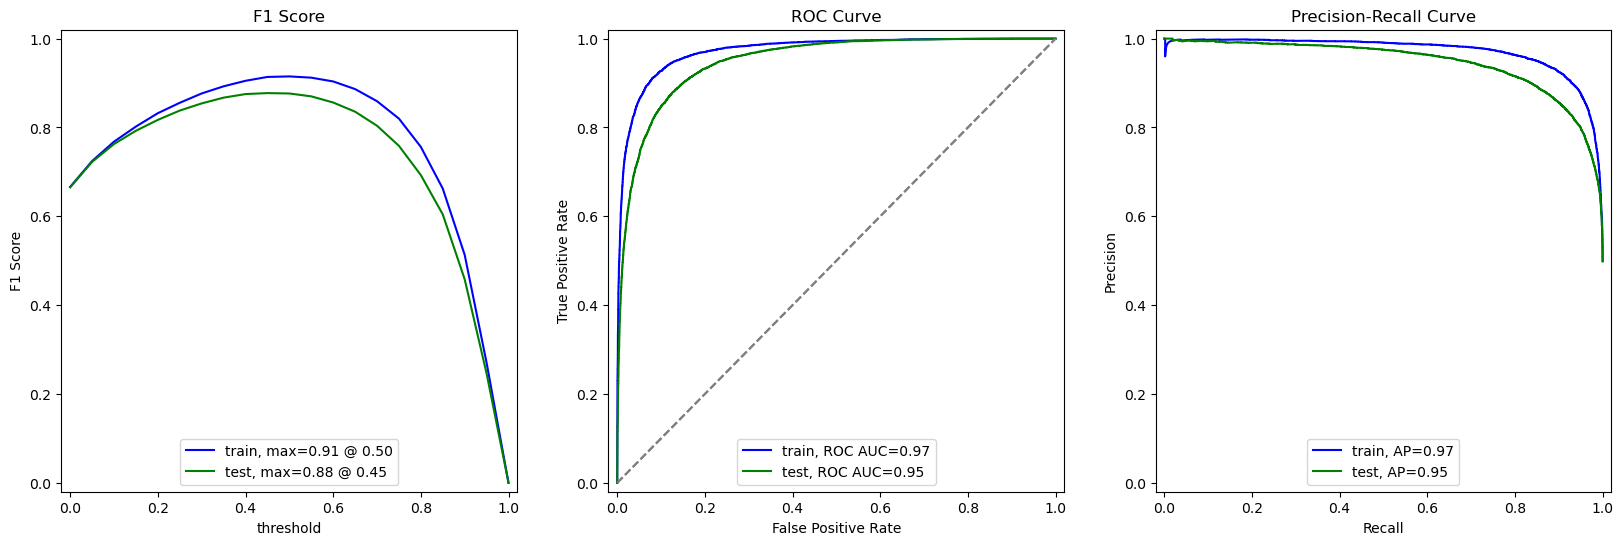

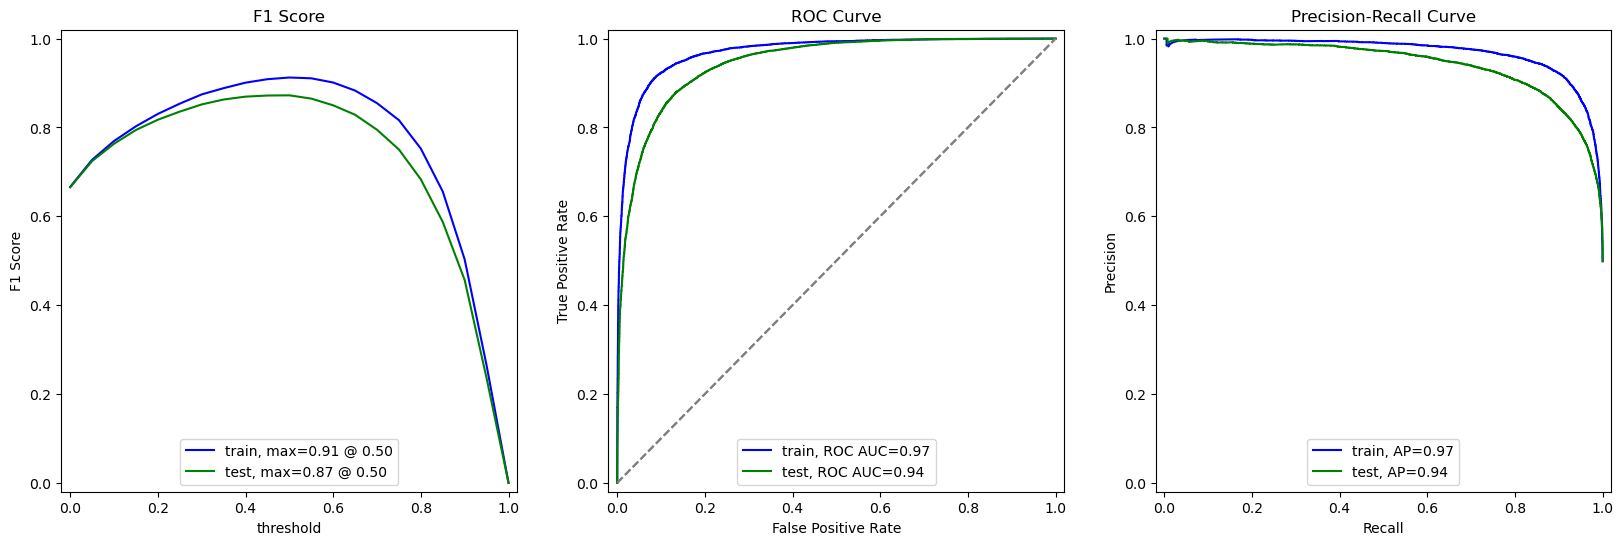

In [32]:
# Función para evaluar el rendimiento de un modelo
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for dataset_type, features, target in [('train', train_features, train_target), ('test', test_features, test_target)]:
        
        eval_stats[dataset_type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba >= threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[dataset_type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[dataset_type]['APS'] = aps
        
        color = 'blue' if dataset_type == 'train' else 'green'

        # Plot F1 Score
        ax = axs[0]
        max_f1_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{dataset_type}, max={f1_scores[max_f1_idx]:.2f} @ {f1_thresholds[max_f1_idx]:.2f}')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1 Score')
        ax.legend(loc='lower center')
        ax.set_title('F1 Score') 

        # Plot ROC Curve
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{dataset_type}, ROC AUC={roc_auc:.2f}')
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower center')        
        ax.set_title('ROC Curve')
        
        # Plot PRC Curve
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{dataset_type}, AP={aps:.2f}')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(loc='lower center')
        ax.set_title('Precision-Recall Curve')        

        eval_stats[dataset_type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[dataset_type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

# Evaluar el Modelo 1 (TF-IDF + LogisticRegression)
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

# Evaluar el Modelo 2 (spaCy + TF-IDF + LogisticRegression)
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

Clasificar reseñas manuales con los modelos entrenados

In [33]:
# Nuevas reseñas manuales para probar los modelos
my_reviews = pd.DataFrame([
    'I absolutely loved this movie, it was fantastic!',
    'This was the worst movie I have ever seen.',
    'The movie had a few good moments, but overall it was just average.',
    'I did not enjoy the acting at all, and the plot was really boring.',
    'A wonderful film! The direction was amazing and the cast was perfect.',
    'It was okay, not great but not terrible either.'
], columns=['review'])

# Normalización de las nuevas reseñas
my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)

# Mostrar las nuevas reseñas normalizadas
print(my_reviews)

                                              review  \
0   I absolutely loved this movie, it was fantastic!   
1         This was the worst movie I have ever seen.   
2  The movie had a few good moments, but overall ...   
3  I did not enjoy the acting at all, and the plo...   
4  A wonderful film! The direction was amazing an...   
5    It was okay, not great but not terrible either.   

                                         review_norm  
0     i absolutely loved this movie it was fantastic  
1          this was the worst movie i have ever seen  
2  the movie had a few good moments but overall i...  
3  i did not enjoy the acting at all and the plot...  
4  a wonderful film the direction was amazing and...  
5      it was okay not great but not terrible either  


In [34]:
# Predicciones con el Modelo 1
my_reviews_features_1 = tfidf_vectorizer.transform(my_reviews['review_norm'])
my_reviews_pred_prob_1 = model_1.predict_proba(my_reviews_features_1)[:, 1]

# Mostrar resultados del Modelo 1
for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f"{my_reviews_pred_prob_1[i]:.2f}:  {review}")

0.97:  I absolutely loved this movie, it was fantastic!
0.00:  This was the worst movie I have ever seen.
0.65:  The movie had a few good moments, but overall it was just average.
0.04:  I did not enjoy the acting at all, and the plot was really boring.
1.00:  A wonderful film! The direction was amazing and the cast was perfect.
0.16:  It was okay, not great but not terrible either.


In [35]:
# Predicciones con el Modelo 2 (lematización con spaCy)
my_reviews['review_lemma'] = my_reviews['review_norm'].apply(spacy_lemmatizer)
my_reviews_features_2 = tfidf_vectorizer_lemma.transform(my_reviews['review_lemma'])
my_reviews_pred_prob_2 = model_2.predict_proba(my_reviews_features_2)[:, 1]

# Mostrar resultados del Modelo 2
for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f"{my_reviews_pred_prob_2[i]:.2f}:  {review}")

0.97:  I absolutely loved this movie, it was fantastic!
0.00:  This was the worst movie I have ever seen.
0.83:  The movie had a few good moments, but overall it was just average.
0.05:  I did not enjoy the acting at all, and the plot was really boring.
1.00:  A wonderful film! The direction was amazing and the cast was perfect.
0.16:  It was okay, not great but not terrible either.


Comparar los resultados de los modelos

In [36]:
# Comparar predicciones entre Modelo 1 y Modelo 2
for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    pred_prob_1 = my_reviews_pred_prob_1[i]
    pred_prob_2 = my_reviews_pred_prob_2[i]
    
    print(f"Reseña: {review}")
    print(f"Modelo 1 (TF-IDF + LR): {pred_prob_1:.2f}")
    print(f"Modelo 2 (spaCy + TF-IDF + LR): {pred_prob_2:.2f}")
    print("-" * 50)

Reseña: I absolutely loved this movie, it was fantastic!
Modelo 1 (TF-IDF + LR): 0.97
Modelo 2 (spaCy + TF-IDF + LR): 0.97
--------------------------------------------------
Reseña: This was the worst movie I have ever seen.
Modelo 1 (TF-IDF + LR): 0.00
Modelo 2 (spaCy + TF-IDF + LR): 0.00
--------------------------------------------------
Reseña: The movie had a few good moments, but overall it was just average.
Modelo 1 (TF-IDF + LR): 0.65
Modelo 2 (spaCy + TF-IDF + LR): 0.83
--------------------------------------------------
Reseña: I did not enjoy the acting at all, and the plot was really boring.
Modelo 1 (TF-IDF + LR): 0.04
Modelo 2 (spaCy + TF-IDF + LR): 0.05
--------------------------------------------------
Reseña: A wonderful film! The direction was amazing and the cast was perfect.
Modelo 1 (TF-IDF + LR): 1.00
Modelo 2 (spaCy + TF-IDF + LR): 1.00
--------------------------------------------------
Reseña: It was okay, not great but not terrible either.
Modelo 1 (TF-IDF + LR):

# Conclusiones y hallazgos finales

Evaluación del Modelo 1 en el conjunto de prueba:
          train  test
Accuracy   0.91  0.88
F1         0.91  0.88
APS        0.97  0.95
ROC AUC    0.97  0.95
Evaluación del Modelo 2 en el conjunto de prueba:
          train  test
Accuracy   0.91  0.87
F1         0.91  0.87
APS        0.97  0.94
ROC AUC    0.97  0.94


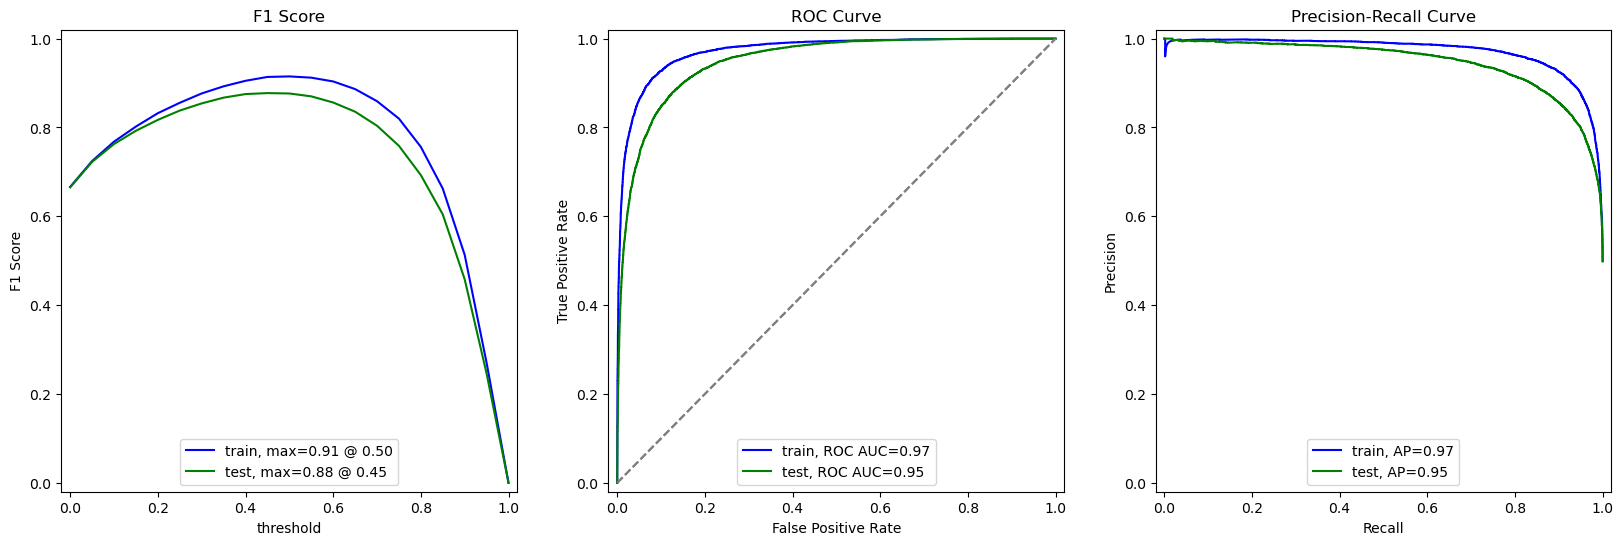

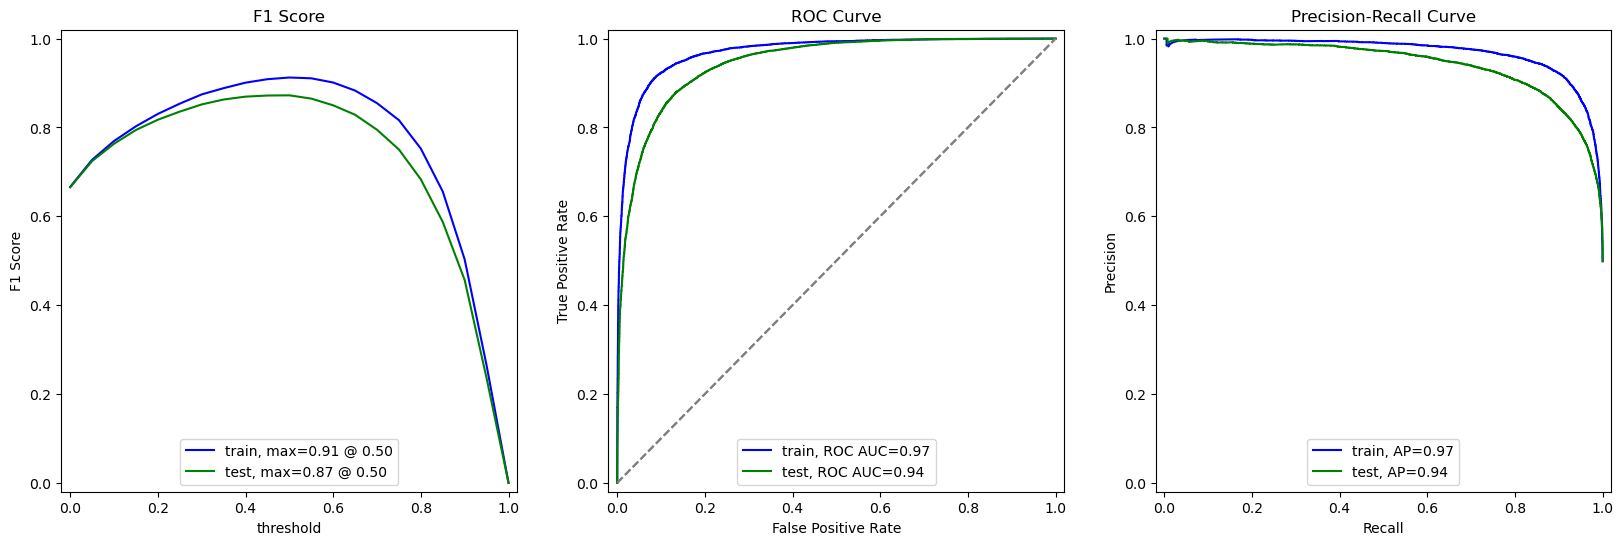

In [37]:
# Evaluación del Modelo 1 (TF-IDF + LR) en el conjunto de prueba
print("Evaluación del Modelo 1 en el conjunto de prueba:")
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

# Evaluación del Modelo 2 (spaCy + TF-IDF + LR) en el conjunto de prueba
print("Evaluación del Modelo 2 en el conjunto de prueba:")
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

Ambos modelos nos permitieron tener un F1 superior al requerido de de 0.85. Debido al gasto computacional que conlleva no se aplicó del modelo BERT, sin embargo, los dos modelos que se aplicaron nos dieron los resultados que esperabamos.